In [1]:
import transformers
from accelerate import init_empty_weights
from transformers import AutoConfig, AutoModelForCausalLM

[2023-07-26 06:21:40,064] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
from utils.add_argument import add_argument
import argparse
import deepspeed
import json

parser = argparse.ArgumentParser(description="MFMds")
parser.add_argument(
    "--dataset-name", type=str, default="PM6-Full-3D", help="dataset name"
)
parser.add_argument(
    "--data_path", type=str, default="./dataset", help="path to dataset"
)
parser.add_argument(
    "--loadcheck_path", type=str, default="", help="path to dataset"
)
parser.add_argument(
    "-b",
    "--batch_size",
    default=1024,
    type=int,
    help="mini-batch size (default: 32)",
)
parser.add_argument(
    "-e",
    "--epochs",
    default=100,
    type=int,
    help="number of total epochs (default: 50)",
)
parser.add_argument(
    "--local_rank",
    type=int,
    default=-1,
    help="local rank passed from distributed launcher",
)
parser.add_argument(
    "--global_rank",
    type=int,
    default=-1,
    help="global rank passed from distributed launcher",
)
parser.add_argument(
    "--backend", type=str, default="nccl", help="distributed backend"
)
parser.add_argument("--seed", type=int, default=666666, help="PRNG seed")
parser.add_argument("--node_rank", type=int, default=-1)
parser.add_argument("--rank", type=int, default=-1)
parser.add_argument("--num-classes", type=int, default=1, help="number of classes")
parser.add_argument(
    "--encoder_embed_dim", type=int, default=768, help="encoder embedding dimension"
)
parser.add_argument("--encoder_ffn_embed_dim", type=int, default=768, help="")
parser.add_argument(
    "--llm_hidden_size", type=int, default=4096, help="encoder embedding dimension"
)
parser.add_argument("--llm_ffn_size", type=int, default=256, help="")
parser.add_argument("--encoder_attention_heads", type=int, default=32, help="")
parser.add_argument("--encoder_layers", type=int, default=24, help="")
parser.add_argument("--max-nodes", type=int, default=8, help="")
parser.add_argument("--add-3d", default=False, action="store_true", help="")
parser.add_argument("--no-2d", default=False, action="store_true", help="")
parser.add_argument("--num-3d-bias-kernel", type=int, default=128, help="")
parser.add_argument("--num_pred_attn_layer", type=int, default=4, help="")
parser.add_argument("--droppath_prob", type=float, default=0.0, help="")
parser.add_argument("--attn_dropout", type=float, default=0.1, help="")
parser.add_argument("--act_dropout", type=float, default=0.1, help="")
parser.add_argument("--dropout", type=float, default=0.0, help="")
parser.add_argument("--weight_decay", type=float, default=0.0, help="")
parser.add_argument("--sandwich_ln", default=True, action="store_true", help="")
parser.add_argument("--infer", action="store_true", default=False, help="")
parser.add_argument("--noise_scale", type=float, default=0.2, help="")
parser.add_argument("--mask_ratio", type=float, default=0.3, help="")
parser.add_argument("--log-interval", type=int, default=100, help="log per n steps")
parser.add_argument(
    "--pipeline_parallelism", type=int, default=0, help="log per n steps"
)
parser.add_argument("--steps", type=int, default=10000000, help="log per n steps")
parser.add_argument(
    "--output_path", type=str, default="/blob/output", help="log per n steps"
)
parser.add_argument(
    "--d_tilde", type=float, default=1, help="mu transfer multiplier"
)
parser.add_argument("--max_lr", type=float, default=1e-3, help="max lr")
parser.add_argument(
    "--total_num_steps",
    type=int,
    default=1000000,
)
parser.add_argument("--warmup_num_steps", type=int, default=60000)

parser.add_argument(
    "--smiles_dict_path",
    type=str,
    default="/home/peiran/FMproj/moleculenet_data/data/mol2idx_dict.jsonl",
)
parser.add_argument(
    "--llm_model_name_or_path",
    type=str,
    default="/home/peiran/FMproj/MetaLLM-converted",
)
parser.add_argument(
    "--loadmfmcheck_path",
    type=str,
    default="/home/peiran/FMproj/DiffTM100M/checkpoint7.pt",
)
parser.add_argument(
    "--loadllmcheck_path", type=str, default="/home/peiran/FMproj/MetaLLM-converted"
)
parser.add_argument(
    "--dataset_names", type=str, default="hiv,clintox,sider,tox21,bbbp,bace"
)
parser.add_argument("--dataset_ratios", type=str, default="")
parser.add_argument("--dataset_splits", type=str, default="")
parser.add_argument("--mol2idx_dict_path", type=str, default="")
parser.add_argument("--in_memory", type=bool, default=False)
parser.add_argument("--mol_size_path", type=str, default="")
parser.add_argument("--pool_mode", type=str, default="qformer")
parser.add_argument("--embedding_length", type=int, default=20)
parser.add_argument("--btn_adaptor", type=bool, default=False)
parser.add_argument("--mfm_lora", type=bool, default=False)
parser.add_argument("--model_max_length", type=int, default=2048)

parser = deepspeed.add_config_arguments(parser)
args, unknown = parser.parse_known_args()

global_step = "global_step4000"


In [3]:
from tqdm import tqdm
import torch


total_size = 0
index_map = {"weight_map": {}}
model_states2 = {}
for i in range(37):
    ckpt_path = "/home/peiran/FMproj/output/" + global_step + f"/layer_{i:02d}-model_states.pt"
    model_states = torch.load(ckpt_path, map_location='cpu')
    # print(ckpt_path)
    all_keys = list(model_states.keys())

    for key in all_keys:
        if key.find('lora') != -1:
            continue
        if key.find("dummy") != -1:
            continue
        if key.find("partial_learnable_emb") != -1:
            continue
        
        weight = model_states.pop(key)
        key = key.replace("base_model.model.", "")

        if i == 0:
            key = "graphormer_encoder." + key
        elif i <= 2:
            if key.startswith("embed_tokens.weight"):
                key = "decoder.model." + key
            else:
                key = "adaptor." + key
        elif i < 35:
            key = "decoder.model.layers.{}.".format(i-3) + key
        elif i == 35:
            key = "decoder.model." + key
        elif i == 36:
            key = "decoder." + key

        # index_map["weight_map"][key] = f"layer_{i:02d}-model_states.bin"
        model_states2[key] = weight
        total_size += weight.nelement() * weight.element_size()
        index_map["weight_map"][key] = f"graphormerllama.bin"
    del model_states

    # torch.save(model_states2, "/home/peiran/FMproj/output/" + global_step + f"/layer_{i:02d}-model_states.bin")
torch.save(model_states2, "/home/peiran/FMproj/output/" + global_step + f"/graphormerllama.bin")
del model_states2
index_map["total_size"] = total_size

with open("/home/peiran/FMproj/output/" +  global_step + "/graphormerlamma.bin.index.json", "w") as out_file:
    json.dump(index_map, out_file)

In [4]:
from models.generalist.graphormer_llama import GraphormerLlamaModel

args.llm_model_name_or_path = "/home/peiran/FMproj/MetaLLM-converted/7B_insft"
args.ft = True

with init_empty_weights():
    model = GraphormerLlamaModel(args, vocab_size=32011)
    # model = LlamaForCausalLM.from_pretrained(args.llm_model_name_or_path)

names = []
for name, parameter in model.named_parameters():
    names.append(name)
# print(names)

json.dump(names, open("/home/peiran/FMproj/output/" + global_step + "/graphormerlamma.json", "w"))

INFO:FoundationModel:Namespace(dataset_name='PM6-Full-3D', data_path='./dataset', loadcheck_path='', batch_size=1024, epochs=100, local_rank=-1, global_rank=-1, backend='nccl', seed=666666, node_rank=-1, rank=-1, num_classes=1, encoder_embed_dim=768, encoder_ffn_embed_dim=768, llm_hidden_size=4096, llm_ffn_size=256, encoder_attention_heads=32, encoder_layers=24, max_nodes=8, add_3d=False, no_2d=False, num_3d_bias_kernel=128, num_pred_attn_layer=4, droppath_prob=0.0, attn_dropout=0.1, act_dropout=0.1, dropout=0.0, weight_decay=0.0, sandwich_ln=True, infer=False, noise_scale=0.2, mask_ratio=0.3, log_interval=100, pipeline_parallelism=0, steps=10000000, output_path='/blob/output', d_tilde=1, max_lr=0.001, total_num_steps=1000000, warmup_num_steps=60000, smiles_dict_path='/home/peiran/FMproj/moleculenet_data/data/mol2idx_dict.jsonl', llm_model_name_or_path='/home/peiran/FMproj/MetaLLM-converted/7B_insft', loadmfmcheck_path='/home/peiran/FMproj/DiffTM100M/checkpoint7.pt', loadllmcheck_path=

In [5]:
from accelerate import load_checkpoint_and_dispatch, infer_auto_device_map, dispatch_model, load_checkpoint_in_model

device_map = infer_auto_device_map(
    model, 
    no_split_module_classes=["LlamaDecoderLayer", "GraphormerSentenceEncoderLayer"],
    dtype='float16'
)
# print(device_map)
full_model_device_map = {k: 0 for k, v in device_map.items()}

# model = load_checkpoint_in_model(
#     model, "/home/peiran/FMproj/output/" + global_step, device_map=device_mpa, dtype='float16', offload_state_dict=True 
# )

# model.decoder.tie_weights()

model = load_checkpoint_and_dispatch(
    model, 
    "/home/peiran/FMproj/output/" + global_step, 
    device_map=full_model_device_map, 
    no_split_module_classes=["LlamaDecoderLayer", "GraphormerSentenceEncoderLayer"],
    offload_state_dict = True, 
    offload_buffers = True, 
    dtype='float16'
)

# full_model_device_map = {f"model.{k}": v for k, v in device_map.items()}
# full_model_device_map["lm_head"] = 0
# dispatch_model(model, device_map=full_model_device_map)

print(model.decoder.model.embed_tokens.weight.shape)
print(model.decoder.lm_head.weight.shape)
model.eval()

torch.Size([32011, 4096])
torch.Size([32011, 4096])


GraphormerLlamaModel(
  (graphormer_encoder): GraphormerSentenceEncoder(
    (dropout_module): FairseqDropout()
    (graph_node_feature): GraphNodeFeature(
      (atom_encoder): Embedding(4609, 768, padding_idx=0)
      (in_degree_encoder): Embedding(512, 768, padding_idx=0)
      (out_degree_encoder): Embedding(512, 768, padding_idx=0)
      (graph_token): Embedding(1, 768)
      (atom_mask_embedding): Embedding(9, 768)
    )
    (graph_attn_bias): GraphAttnBias(
      (edge_encoder): Embedding(1537, 32, padding_idx=0)
      (edge_dis_encoder): Embedding(3276800, 1)
      (spatial_pos_encoder): Embedding(522, 800, padding_idx=0)
      (graph_token_virtual_distance): Embedding(1, 800)
    )
    (emb_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-23): 24 x GraphormerSentenceEncoderLayer(
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (self_attn): MultiheadAttention(
         

In [6]:
from data.mol_data.tokenizer import MolTokenizer
from utils.move_to_device import move_to_device
import torch
args.llm_model_name_or_path = "/home/peiran/FMproj/MetaLLM-converted/7B_insft"

tokenizer = MolTokenizer(args)

# batched_smile_data = move_to_device(batched_smile_data, 'cuda:1')
# model.decoder.tie_weights()


INFO:rdkit:Enabling RDKit 2021.09.3 jupyter extensions


In [25]:
# text = ["#Prompt: The smile of the molecule is <mol> c1ccc(C2CN=C3NCCN32)cc1 </mol>, give its description"]
# text = ["### Instruction: \nWhat can you tell me about this molecule?\n  ###Input: <mol> CCCCCc1cccc([C@@]2(c3ccc(OC(F)F)cc3)N=C(N)N(C)C2=O)c1 </mol> ### Response:\n"]
# text = ["### Instruction:\nWhat can you tell me about this molecule?\n  ###Input: <mol> c1ccc(C2CN=C3NCCN32)cc1 </mol> ### Response:\n"]
# text = ["### Instruction:\nWhat can you tell me about this molecule?\n  ###Input: <mol> C1=C(OC(=C1)C(=O)OCCO)C(=O)[O-1] </mol> ### Response:\n"]
# text = ["### Instruction:\nWhat can you tell me about this molecule?\n  ###Input: <mol> CC1=CC(=NC(=C1)C)C </mol> ### Response:\n"]
# text = ["### Instruction:\nWhat can you tell me about this molecule?\n\n###Input:\n<mol>CCC(CC(C)(C)C(=O)O)C1=CC=CC=C1</mol>\n\n### Response:\n"]
# text = ["### Instruction:\nProvide a brief overview of this molecule.\n\n###Input:\n<mol>CC(=O)C</mol>\n\n### Response:\n"]

smile_list = ["CCCCCc1cccc([C@@]2(c3ccc(OC(F)F)cc3)N=C(N)N(C)C2=O)c1", 
              "c1ccc(C2CN=C3NCCN32)cc1", 
              "C1=C(OC(=C1)C(=O)OCCO)C(=O)[O-1]", 
              "CC1=CC(=NC(=C1)C)C",
              "CCC(CC(C)(C)C(=O)O)C1=CC=CC=C1", 
              "O=C(COc1ccc(Cl)cc1)OCCNC12CC3CC(CC(C3)C1)C2",
              "CC(=O)C",
              "C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(=O)=O",
              "CC[C@@]1(O)C[C@H](O[C@H]2C[C@H](N(C)C)[C@H](O[C@H]3C[C@@H]4O[C@H]5CC(=O)[C@H](C)O[C@H]5O[C@@H]4[C@H](C)O3)[C@H](C)O2)c2c(O)c3c(c(O)c2[C@H]1O[C@H]1C[C@H](N(C)C)[C@H](O)[C@H](C)O1)C(=O)c1cccc(O)c1C3=O", #inactive
              "CCCNCC(O)COc1ccccc1C(=O)CCc1ccccc1", 
              "CC(=O)NCCn1c(C)cc(C=O)c1C", #active
              "O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2[C@H]1CN1CCCC1", #active
              "CC1(C2=C(C=CC(=C2)S(=O)(=O)[O-1])[N+1](=C1/C=C/C3=C(/C(=C/C=C/4\\C(C5=C(N4CCCCS(=O)(=O)O)C=CC(=C5)S(=O)(=O)O)(C)C)/CCC3)OC6=CC=C(C=C6)C[C@@H1](C(=O)O)NC(=O)C7=CC=C(C=C7)NCC8=CN=C9C(=N8)C(=O)NC(=N9)N)CCCCS(=O)(=O)O)C",
              "O=C(O)Cc1ccc(N2N=C(c3ccccc3)CC2=O)cc1",
              "CC(=O)OCC(=O)C12OC3(CCCC3)OC1CC1C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC12C",
              'O=C(O)CC1C(=O)OC2C3COC(=O)c4cc(O)c(O)c(O)c4-c4c(cc(O)c(O)c4O)C(=O)OC2C(OC(=O)c2cc(O)c(O)c4c2C1C(O)C(=O)O4)C(OC(=O)c1cc(O)c(O)c(O)c1)O3',
              "COc1cc(-c2nn3c(C)c(-c4ccccc4)nc3s2)cc(OC)c1OC",
              "CCO",
              "CC(C(C1=CC=CC=C1)O)NC.Cl",
              ]

question_list = ["Is this molecule toxic and why?",
                 "Is the molecule easily soluble in water and why?",
                 "Does the molecule has good oral bioavailability and why?",
                 "Can the molecule pass the blood-brain barrier and why?",
                 "Whether the molecule can pass the blood-brain barrier?",
                 "Provide a brief overview of this molecule.",
                 "The number of Carbon atom in this molecule is?",
                 "Could you provide a description this molecule?",
                 "What the most important feature of this molecule?",
                 "Whether the molecule can inhibit HIV replication and why?",
                 "Whether the drug can cause blood and lymphatic system disorders and why?",
                 "Whether the drug can treat HIV and why?",
                 "What is potential side effect of this drug and why?",
                 ]

smile = smile_list[8]
question = question_list[3]
text = ["### Instruction:\n{}\n\n### Input: <mol>{}</mol> ### Response:\n".format(question, smile)]

# text = ["### Instruction:\nIs this molecule toxic\n\n###Input:\n<mol>CCCCCc1cccc([C@@]2(c3ccc(OC(F)F)cc3)N=C(N)N(C)C2=O)c1</mol>\n\n### Response:\n"]
# text = ["### Instruction:\nIs this molecule able to penetrate blood-brain barrier.\n\n###Input:\n<mol> CCCCCc1cccc([C@@]2(c3ccc(OC(F)F)cc3)N=C(N)N(C)C2=O)c1 </mol>\n\n### Response:\n"]

# text = ["The smile of the molecule is <mol>CCO</mol>, provide a description of this molecule: "]
# text = ["To fix a broken audio device in my laptop"]
input_ids, batched_smile_data, llm_mask = tokenizer.tokenize(text)
# print(input_ids)
maksed_input_ids = torch.where(input_ids>0, input_ids, 0)
inputtext = tokenizer.text_tokenizer.decode(maksed_input_ids[0], skip_special_tokens=False)
# print(maksed_input_ids)
print("smile: ", smile)

print(inputtext)
input_ids = input_ids.to('cuda:0')
llm_mask = llm_mask.to('cuda:0')
res = model.generate(batched_smile_data, input_ids=input_ids, attention_mask=llm_mask, do_sample=True, temperature=0.9, max_new_tokens=256, output_scores=True, return_dict_in_generate=True)
# print(res.sequences[0])
# print(text)
res = tokenizer.text_tokenizer.decode(res.sequences[0], skip_special_tokens=False)
print(res)

smile:  CC[C@@]1(O)C[C@H](O[C@H]2C[C@H](N(C)C)[C@H](O[C@H]3C[C@@H]4O[C@H]5CC(=O)[C@H](C)O[C@H]5O[C@@H]4[C@H](C)O3)[C@H](C)O2)c2c(O)c3c(c(O)c2[C@H]1O[C@H]1C[C@H](N(C)C)[C@H](O)[C@H](C)O1)C(=O)c1cccc(O)c1C3=O
<s>### Instruction:
Can the molecule pass the blood-brain barrier and why?

### Input: <mol> <unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk> </mol> ### Response:

<s> The molecule, with both methyl and ethyl groups, is predicted to be a permeable compound with the ability to cross the blood-brain barrier.

### Experimental evidences behind the prediction

The [2.71](4)-3.41(4) Å resolution crystal structure of ALDH2 has been determined by X-ray diffraction. This structure has been optimized for all but one atom, and the rest of the atoms have been refined to 0.19 to 1.68 Å. The ligand-binding pocket of the active site consists of two pockets: a deep central pore surrounded by a shallow ring. This ligand binding site was found to b

In [8]:

# text = ["###Prompt\nDoes <mol> O=S(=O)([O-])[O-].[NH4+].[NH4+] </mol> can react with <mol> NC(=O)c1ccccc1 </mol> and what is the product?\n###Response:\n"]
# smile1 = "Cc1ccc(/C=C2\\C(=O)C3(C)CCC2C3(C)C)cc1"
# smile2 = "C[Si](C)(C)n1ccnc1"
smile1 = "CCO"
smile2 = "CC(=O)O"
smile3 = "CC1=CC(=NC(=C1)C)C"
# text = ["### Instruction:\nDoes two molecules react with each other and what is the product?\n\n### Input:\n<mol> {} </mol>\n <mol> {} </mol> ### Response:\n".format(smile1, smile2)]
# text = ["### Instruction:\nWhat compounds is need to synthesis the molecule?\n\n### Input:\n<mol> {} </mol> ### Response:\n".format(smile3)]
text = ["Does molecules <mol> {} </mol> react with <mol> {} </mol> and what is the product?".format(smile1, smile2)]

# text = ['### Instruction:\n\nThis is a reaction question.\n\n###Input:\nWhat molecule can this molecule <mol> {} </mol> react with? ### Output:\n'.format(smile1)]
# text = ["### Instruction:\nDoes <mol> {} </mol> react with <mol> {} </mol> and what is the product?\n\n### Input:\n<mol> {} </mol> <mol> {} </mol>\n\n### Response:\n".format(smile1, smile2, smile1, smile2)]

# text = ["###Prompt\nHow to sythesis <mol> C=CCC#N </mol>\n###Response:\n"]

input_ids, batched_smile_data, llm_mask = tokenizer.tokenize(text)
# text_list, smile_list, _ = tokenizer.split_text_and_mol(text)

# print(text_list, smile_list);exit()
print(input_ids)
# maksed_input_ids = torch.where(input_ids>0, input_ids, 0)
# inputtext = tokenizer.text_tokenizer.decode(maksed_input_ids[0], skip_special_tokens=False)
# print(inputtext)

input_ids = input_ids.to('cuda:0')
llm_mask = llm_mask.to('cuda:0')
res = model.generate(batched_smile_data, input_ids=input_ids, attention_mask=llm_mask, do_sample=True, temperature=0.7, max_new_tokens=512, output_scores=True, return_dict_in_generate=True)
res = tokenizer.text_tokenizer.decode(res.sequences[0], skip_special_tokens=False)
print(text)
print(res)



tensor([[    1,  5538, 13206, 21337, 32001,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1, 32002,  7657,   411, 32001,    -2,
            -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,
            -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2, 32002,
           322,   825,   338,   278,  3234, 29973]])
['Does molecules <mol> CCO </mol> react with <mol> CC(=O)O </mol> and what is the product?']
<s>
When the product of a function is found by evaluating the function at a given value.
The product of a function is its output when it is evaluated at a single argument.
When the product of a function is found by evaluating the function at a given value
and what is the product of a function?
The product of a function is its output when it is evaluated at a single argument.
The product of a function is its output when it is evaluated at a given value
Wha

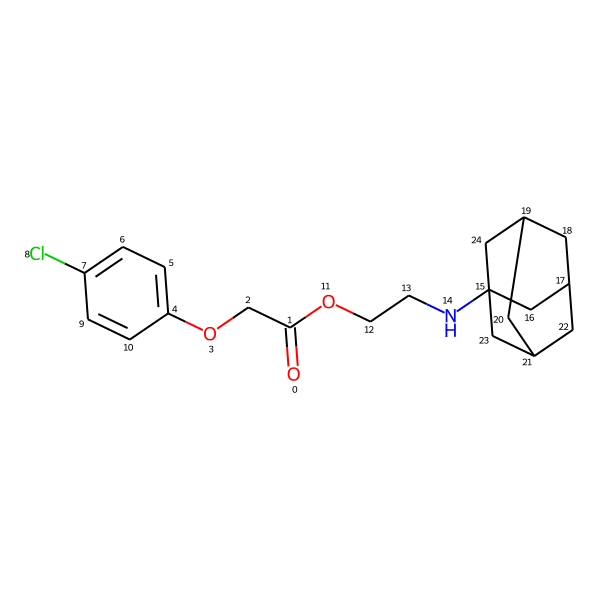

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 600,600

mol = Chem.MolFromSmiles('O=C(COc1ccc(Cl)cc1)OCCNC12CC3CC(CC(C3)C1)C2 ')
mol

# def mol_with_atom_index(mol):
#     for atom in mol.GetAtoms():
#         atom.SetAtomMapNum(atom.GetIdx())
#     return mol
# mol_with_atom_index(mol)